# Restaurant Revenue Prediction

> **Goal**: Using demographic, real estate, and commercial data, this competition challenges you to predict the annual restaurant sales of 100,000 regional locations.

> **Evaluaton Metric**: RMSE(Root Mean Squared Error)

## Data Source

* Kaggle: https://www.kaggle.com/c/restaurant-revenue-prediction/overview

## Data Fields

1. **Id**: Restaurant id. 
2. **Open Date**: opening date for a restaurant
3. **City**: City that the restaurant is in. Note that there are unicode in the names. 
4. **City Group**: Type of the city. Big cities, or Other. 
5. **Type**: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile
6. **P1, P2 - P37**: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
7. **Revenue**: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 


### About the company

* TFI has over 1,200 quick service restaurants across the globe.
* They employ over 20,000 people in Europe and Asia.
* They make significant investments in their niche.
* When the wrong location for a restaurant brand is chosen, the site closes within 18 months and operating losses are incurred.
* Their goal is to increase effectiveness in their investments.

> You have the opening dates, cities, types of cities, types of restaurants and obfuscated data to predict the revenue

## References
1. https://towardsdatascience.com/restaurant-revenue-prediction-467f0990403e
2. https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Data Preparation 

In [2]:
# Load training data
data_train = pd.read_csv("../input/restaurant-revenue-prediction/train.csv.zip")

In [3]:
data_train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          137 non-null    int64  
 1   Open Date   137 non-null    object 
 2   City        137 non-null    object 
 3   City Group  137 non-null    object 
 4   Type        137 non-null    object 
 5   P1          137 non-null    int64  
 6   P2          137 non-null    float64
 7   P3          137 non-null    float64
 8   P4          137 non-null    float64
 9   P5          137 non-null    int64  
 10  P6          137 non-null    int64  
 11  P7          137 non-null    int64  
 12  P8          137 non-null    int64  
 13  P9          137 non-null    int64  
 14  P10         137 non-null    int64  
 15  P11         137 non-null    int64  
 16  P12         137 non-null    int64  
 17  P13         137 non-null    float64
 18  P14         137 non-null    int64  
 19  P15         137 non-null    i

In [5]:
# Check for null values
data_train.isna().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

In [6]:
# Check all the cities and provinces we are dealing with
data_train.City.unique()

array(['İstanbul', 'Ankara', 'Diyarbakır', 'Tokat', 'Gaziantep',
       'Afyonkarahisar', 'Edirne', 'Kocaeli', 'Bursa', 'İzmir', 'Sakarya',
       'Elazığ', 'Kayseri', 'Eskişehir', 'Şanlıurfa', 'Samsun', 'Adana',
       'Antalya', 'Kastamonu', 'Uşak', 'Muğla', 'Kırklareli', 'Konya',
       'Karabük', 'Tekirdağ', 'Denizli', 'Balıkesir', 'Aydın', 'Amasya',
       'Kütahya', 'Bolu', 'Trabzon', 'Isparta', 'Osmaniye'], dtype=object)

In [7]:
# The number of provinces and cities in our data
len(data_train.City.unique())

34

In [9]:
# Types of cities we are dealing with
data_train['City Group'].unique()

array(['Big Cities', 'Other'], dtype=object)

Big Cities    78
Other         59
Name: City Group, dtype: int64

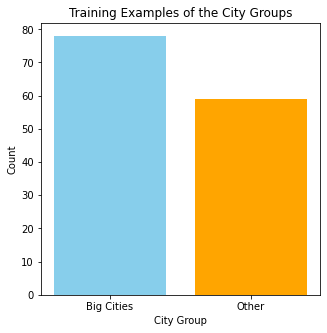

In [10]:
bigCities = len(data_train[data_train['City Group'] == "Big Cities"])
otherCount = len(data_train[data_train['City Group'] == "Other"])
dic_1 = {"Big Cities": bigCities, "Other": otherCount}

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(dic_1.keys(), 
       dic_1.values(), 
       width=0.8, 
       color=['skyblue', 'orange'])
ax.set(xlabel= "City Group", 
       ylabel='Count',
       title='Training Examples of the City Groups');
data_train['City Group'].value_counts()

In [11]:
data_train['Type'].value_counts()

FC    76
IL    60
DT     1
Name: Type, dtype: int64

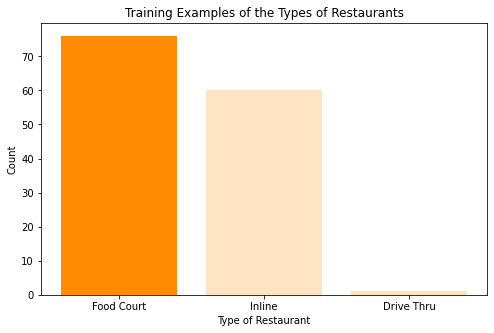

In [12]:
fc = len(data_train[data_train['Type'] == "FC"])
il = len(data_train[data_train['Type'] == "IL"])
dt = len(data_train[data_train['Type'] == "DT"])
dic_2 = {'Food Court': fc ,"Inline": il , "Drive Thru": dt}

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(dic_2.keys(), 
       dic_2.values(), 
       width=0.8, 
       color=['darkorange', 'bisque', 'moccasin'])
ax.set(xlabel='Type of Restaurant', 
       ylabel='Count',
       title='Training Examples of the Types of Restaurants');

In [13]:
data_train['Open Date'].dtype

dtype('O')

In [14]:
# Convert the Open Date column to the datetime data type
data_train['Open Date'] = pd.to_datetime(data_train['Open Date'])

In [15]:
data_train['Open Date'].dtype

dtype('<M8[ns]')

In [16]:
# Sort the values by year in ascending order
data_train.sort_values(by=['Open Date'], inplace=True, ascending=True, ignore_index=True)

In [17]:
data_train = data_train.drop('Id', axis=1)

In [18]:
data_train.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,1996-05-08,Adana,Other,IL,4,5.0,4.0,3.0,1,2,...,2.0,4,1,3,3,3,4,3,3,3903884.0
1,1997-04-10,İstanbul,Big Cities,IL,12,7.5,6.0,7.5,2,8,...,2.5,25,15,25,6,18,3,16,6,4286645.0
2,1998-01-28,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,3,...,2.0,3,5,5,2,3,5,4,4,4705945.0
3,1998-03-14,İstanbul,Big Cities,IL,4,5.0,5.0,4.0,1,5,...,3.0,3,2,1,2,2,1,3,3,3784230.0
4,1998-07-13,İstanbul,Big Cities,IL,12,7.5,6.0,6.0,2,8,...,7.5,20,15,25,4,24,15,20,6,2551252.0


In [19]:
# Add seperate columns for the Open date values
data_train['Sale Day'] = data_train['Open Date'].dt.day
data_train['Sale Year'] = data_train['Open Date'].dt.year
data_train['Sale Month'] = data_train['Open Date'].dt.month

In [20]:
data_train.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P32,P33,P34,P35,P36,P37,revenue,Sale Day,Sale Year,Sale Month
0,1996-05-08,Adana,Other,IL,4,5.0,4.0,3.0,1,2,...,3,3,3,4,3,3,3903884.0,8,1996,5
1,1997-04-10,İstanbul,Big Cities,IL,12,7.5,6.0,7.5,2,8,...,25,6,18,3,16,6,4286645.0,10,1997,4
2,1998-01-28,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,3,...,5,2,3,5,4,4,4705945.0,28,1998,1
3,1998-03-14,İstanbul,Big Cities,IL,4,5.0,5.0,4.0,1,5,...,1,2,2,1,3,3,3784230.0,14,1998,3
4,1998-07-13,İstanbul,Big Cities,IL,12,7.5,6.0,6.0,2,8,...,25,4,24,15,20,6,2551252.0,13,1998,7


In [21]:
data_train['Sale Year'].value_counts()

2011    25
2012    18
2009    16
2010    15
2008    14
2013    12
2006     7
2007     7
1998     4
1999     4
2005     4
2004     3
2014     2
2002     2
2000     2
1997     1
1996     1
Name: Sale Year, dtype: int64

In [22]:
# Store categorical variable names in a list
ctg_vars = []

for col in data_train:
    if len(data_train[col].unique()) <= 30:
        ctg_vars.append(col)

In [23]:
# Remove the P variables from categorical variables' list
i = 1
for k in range(1, 43):
    for p in ctg_vars:
        if p == "P" + str(i):
            ctg_vars.remove("P" + str(i))
            i += 1

In [24]:
print(ctg_vars)

['City Group', 'Type', 'Sale Day', 'Sale Year', 'Sale Month']


In [25]:
len(ctg_vars)

5

## Exploratory Data Analysis

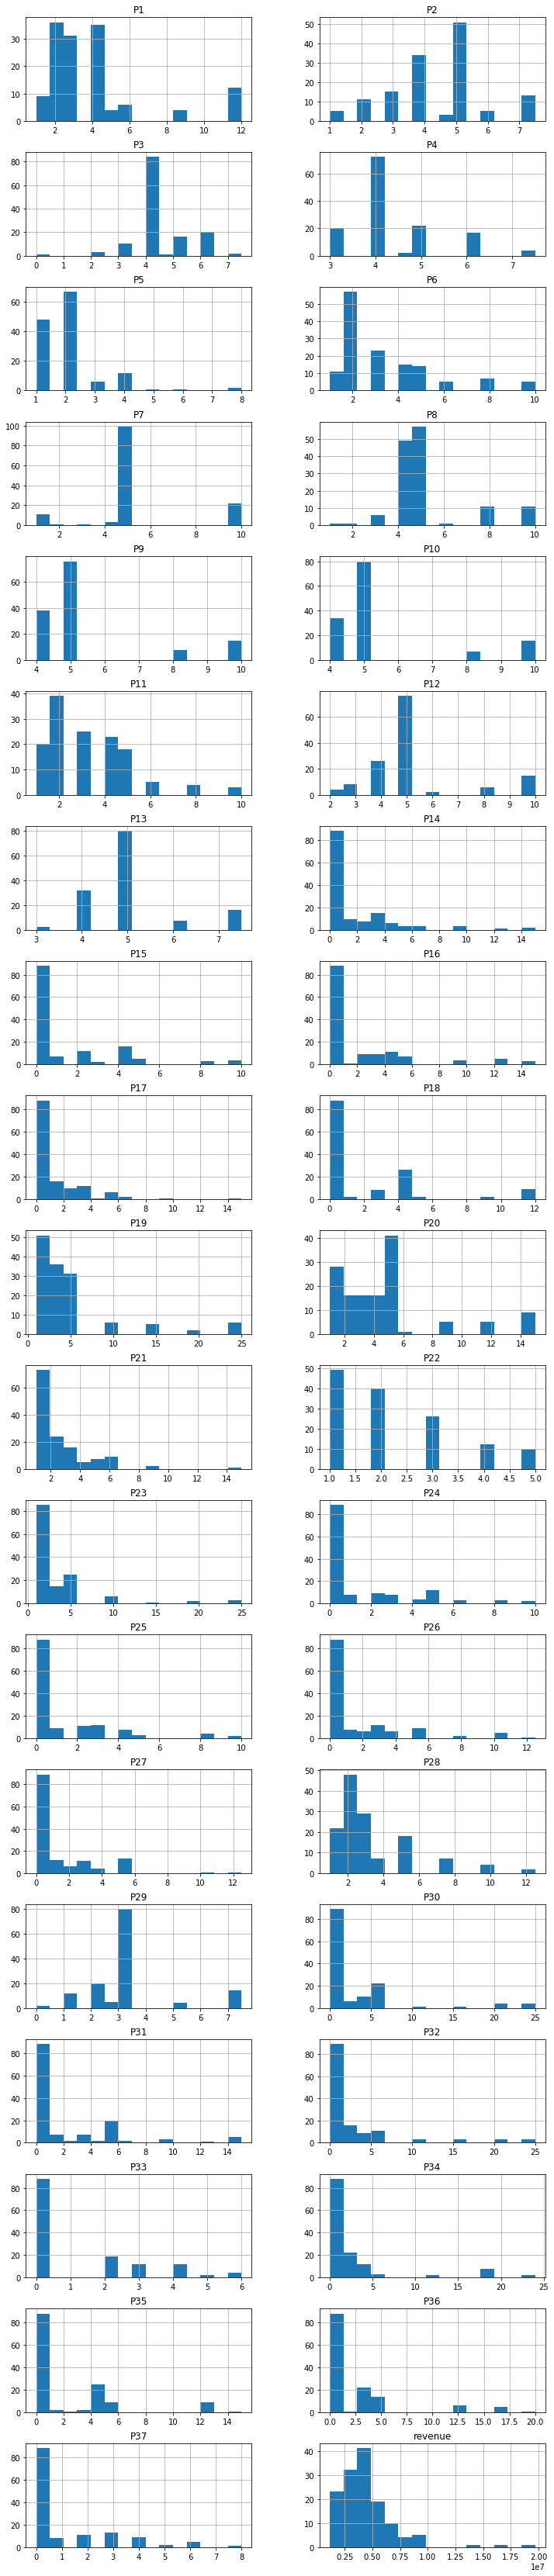

In [26]:
#Plot histograms for all the P columns and the revenue column
hist_cols = list(data_train.columns[4:42])
data_train[hist_cols].hist(figsize= (12,60), layout=(19,2), bins=15);

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


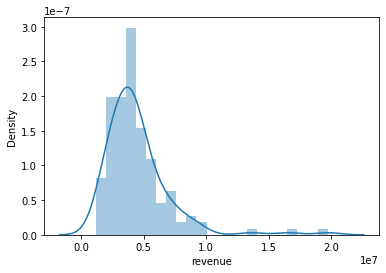

In [27]:
sns.distplot(data_train['revenue']);

> We can observe that the revenue independent variable is rightly skewed

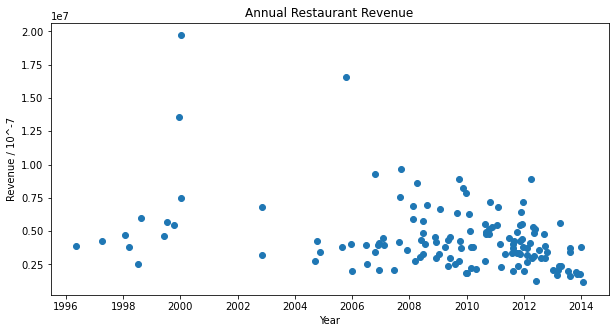

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(data_train['Open Date'], data_train['revenue'])
ax.set(ylabel="Revenue / 10^-7",
       xlabel='Year',
       title='Annual Restaurant Revenue');

Median Revenue of Big cities: 4234908.0
Median Revenue of Other cities: 3745135.0


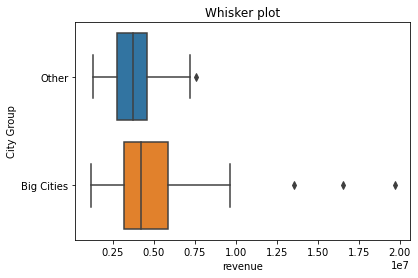

In [29]:
# Median Revenue of big cities and other cities
ax_wp_1 = sns.boxplot(x='revenue', y='City Group', data=data_train)
ax_wp_1.set(title='Whisker plot');

bc_median = data_train[data_train['City Group'] == 'Big Cities']['revenue'].median()
oc_median = data_train[data_train['City Group'] == 'Other']['revenue'].median()
print("Median Revenue of Big cities:", bc_median)
print("Median Revenue of Other cities:", oc_median)

In [30]:
data_train['revenue'].max()

19696939.0

In [31]:
# Median revenue for the types of restaurants
rt_median = data_train.groupby('Type')['revenue'].aggregate(np.median)
print("Median Revenue of the types of restaurants per annum: \n", rt_median[1:])

Median Revenue of the types of restaurants per annum: 
 Type
FC    3873650.0
IL    4076087.0
Name: revenue, dtype: float64


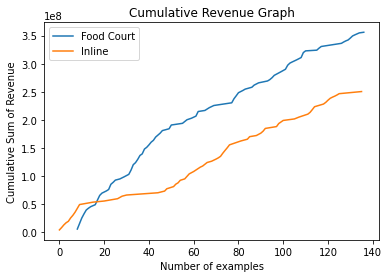

In [32]:
data_train[data_train['Type'] == 'FC']['revenue'].cumsum().plot()
data_train[data_train['Type'] == 'IL']['revenue'].cumsum().plot()
plt.ylabel('Cumulative Sum of Revenue')
plt.xlabel('Number of examples')
plt.legend(['Food Court', 'Inline'])
plt.title('Cumulative Revenue Graph');

In [33]:
# Type of restaurant with the most revenue
data_train[data_train['revenue'] == data_train['revenue'].max()]['Type']

10    FC
Name: Type, dtype: object

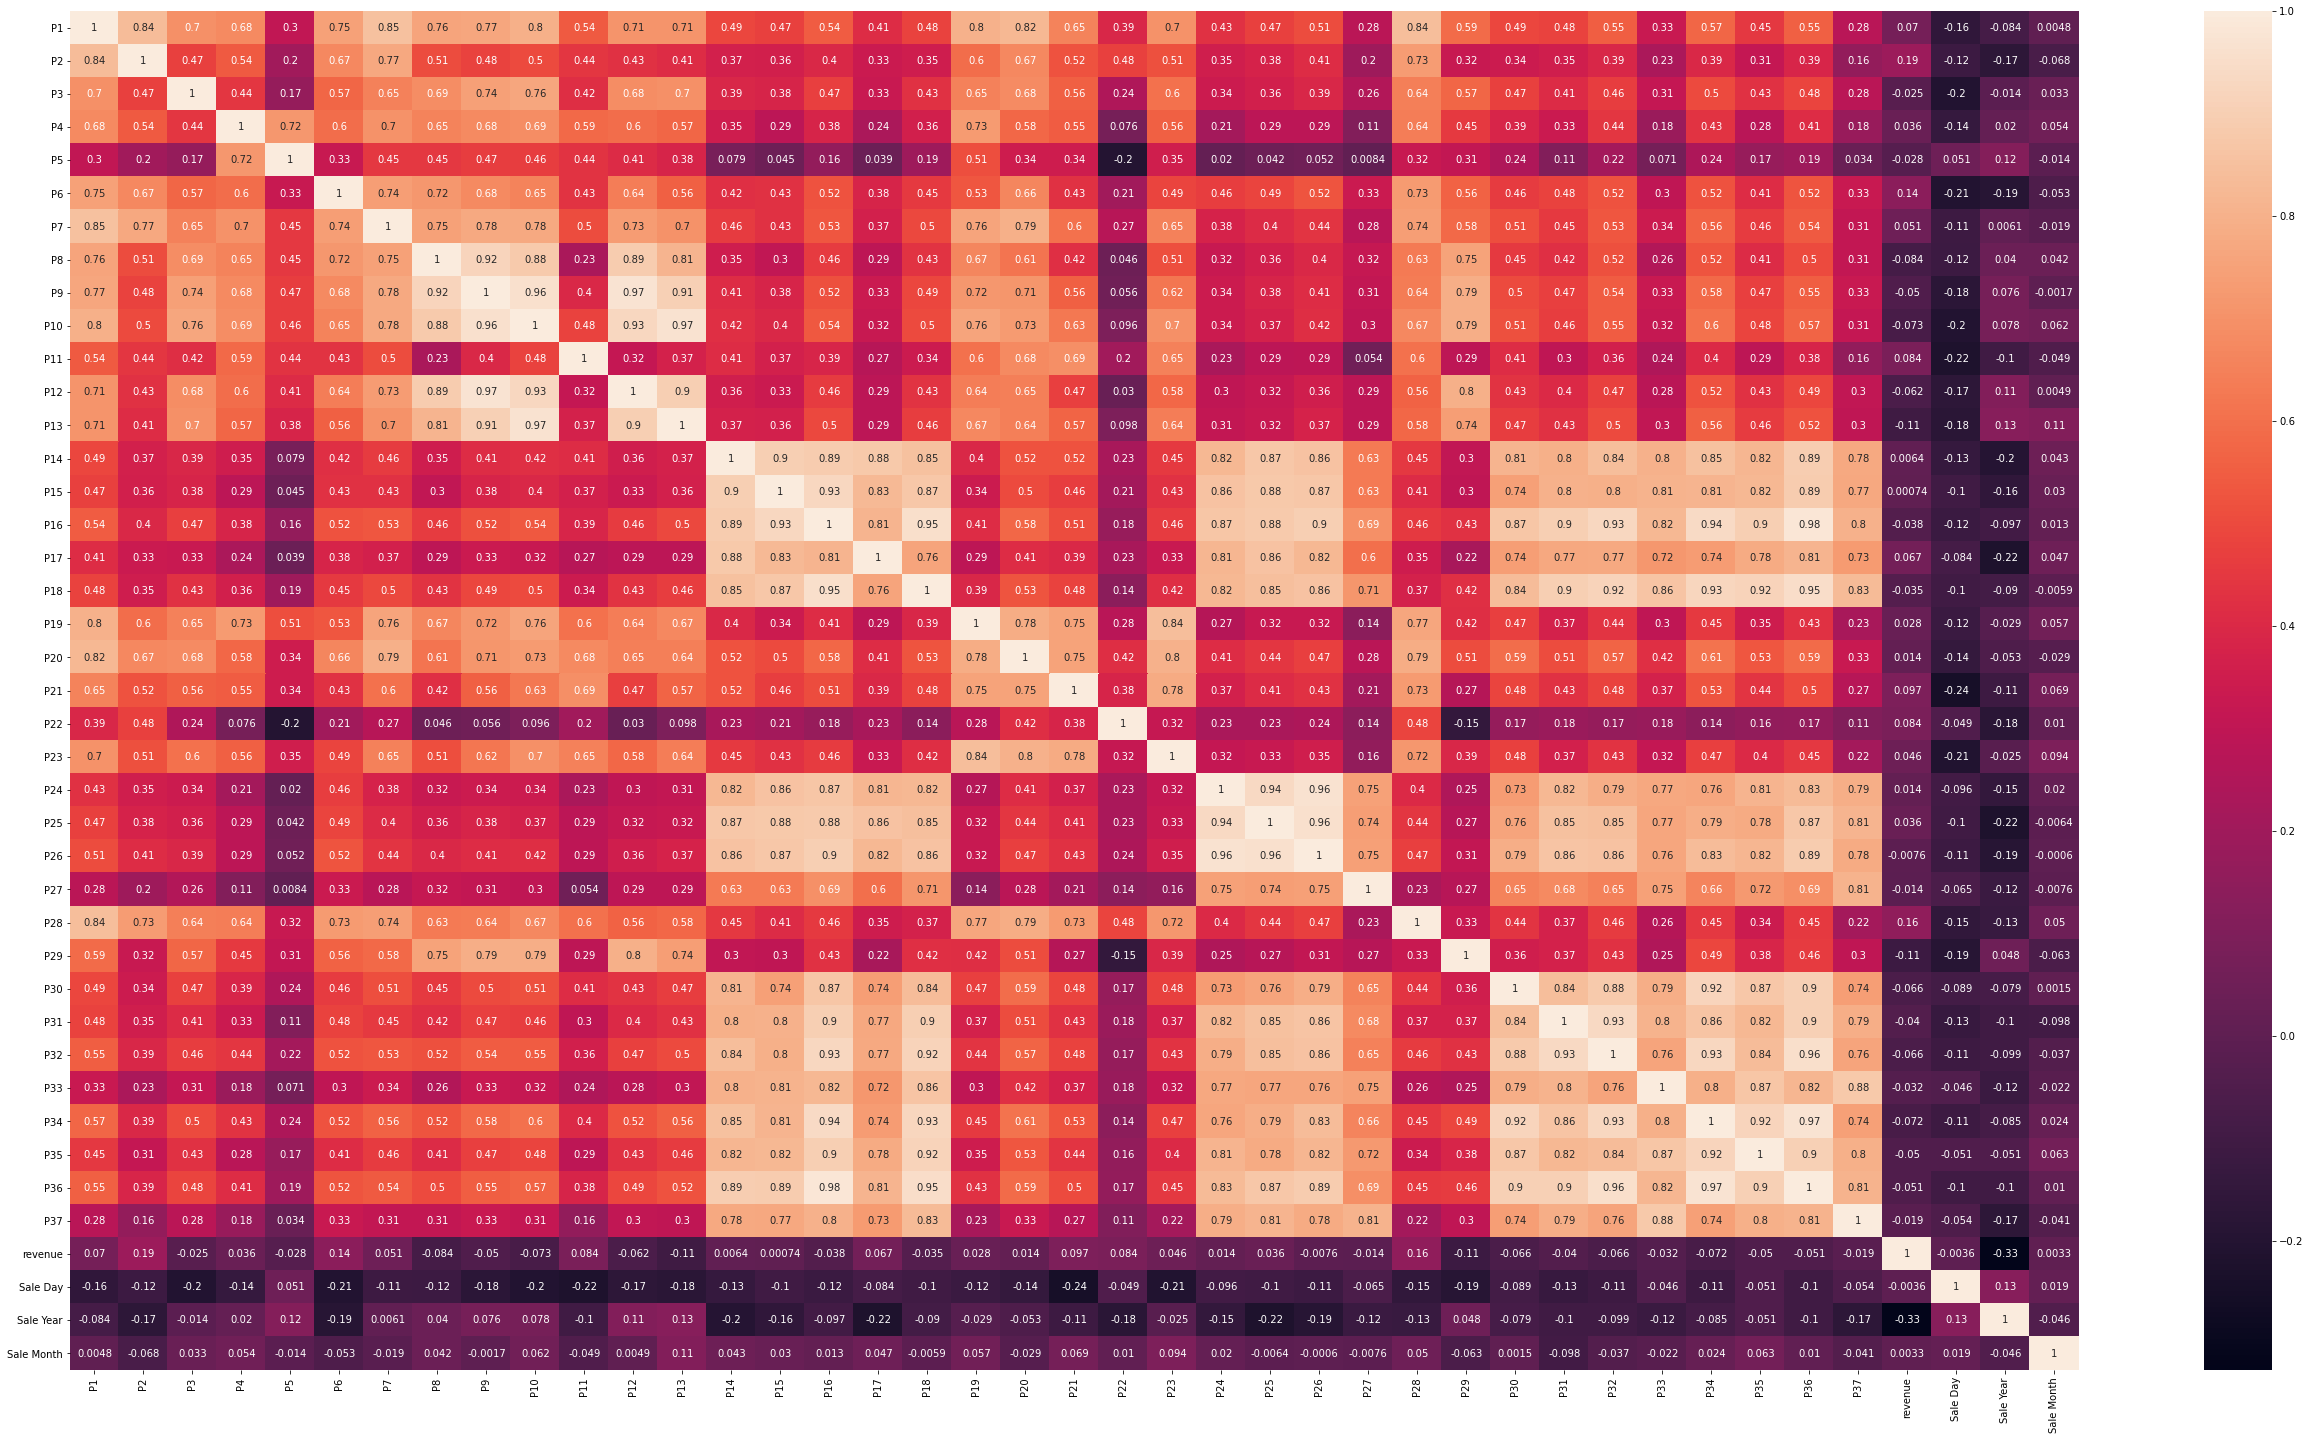

In [34]:
plt.figure(figsize=(45,25))
sns.heatmap(data_train.corr(),annot=True)
sns.set(font_scale=1.4)

## Imputing Null P values

In [35]:
# P variables will be considered as continous variables rather than categorical variables
imp_train = IterativeImputer(max_iter=30, random_state=0, missing_values=0, sample_posterior = True, min_value=1)
p_vals = ["P" + str(i) for i in range(1, 38)]
data_train[p_vals] = np.round(imp_train.fit_transform(data_train[p_vals]))

### Save changes made to the data in another file

In [36]:
data_temp = data_train.copy()

In [37]:
data_temp.drop('Open Date', axis=1, inplace=True)
data_temp.drop('City', axis=1, inplace=True)

In [38]:
data_temp['revenue'] = np.log1p(data_temp['revenue'])

In [39]:
data_temp.to_csv('train_data_modified.csv', index=False)

## Modelling

> **Regression models**:
*  Random Forest
* CatBoost 

In [40]:
# Load the temp data
data = pd.read_csv('train_data_modified.csv')

In [41]:
data = pd.get_dummies(data, columns=ctg_vars)

 These columns are missing from the training data which will become an issue when the input features from our test set will not match the input features from our training set
- Sale Year_1995
- Sale Year_2001
- Sale Year_2003
- Sale Day_19

In [42]:
# Add new columns to our dataset to match our input features
data['Sale Year_1995'] = pd.DataFrame(np.zeros((137, 1)), dtype='uint8')
data['Sale Year_2001'] = pd.DataFrame(np.zeros((137, 1)), dtype='uint8')
data['Sale Year_2003'] = pd.DataFrame(np.zeros((137, 1)), dtype='uint8')
data['Sale Day_19'] = pd.DataFrame(np.zeros((137, 1)), dtype='uint8')

In [43]:
X = data.drop('revenue', axis=1)
y = data['revenue']

In [44]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

In [45]:
# Create Random Forest Regressor model
model = RandomForestRegressor(n_estimators=1000 ,random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=0)

In [46]:
# Evaluation Function

def rmse(y_test, y_preds):
    return np.sqrt(mean_squared_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Validating MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSE": rmse(y_train, train_preds),
              "Validating RMSE": rmse(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Validating R^2": model.score(X_valid, y_valid)}
    return scores

In [47]:
show_scores(model)

{'Training MAE': 0.12489855974713038,
 'Validating MAE': 0.3172497701826527,
 'Training RMSE': 0.16497358279454652,
 'Validating RMSE': 0.3453663263458902,
 'Training R^2': 0.8859164183416651,
 'Validating R^2': 0.15095526573718443}

In [48]:
# Model 2 - CatBoost
from catboost import CatBoostRegressor
model_2 = CatBoostRegressor(verbose=False)
model_2.fit(X_train, y_train);

In [49]:
cat_pred = model_2.predict(X_valid)

In [50]:
show_scores(model_2)

{'Training MAE': 0.013133632065670406,
 'Validating MAE': 0.28651832304131325,
 'Training RMSE': 0.01603702200058821,
 'Validating RMSE': 0.32806297744636376,
 'Training R^2': 0.9989219428484492,
 'Validating R^2': 0.23390075364152052}

## Hyperparameter Tuning

### Random Forest

In [51]:
# Number of trees
trees = np.arange(100, 1000, 100)

for i in trees:
    print("Number of Trees: {}".format(i))
    rf_test_model = RandomForestRegressor(n_estimators=i, random_state=0, criterion='mae')
    rf_test_model.fit(X_train, y_train)
    train_preds = rf_test_model.predict(X_train)
    val_preds = rf_test_model.predict(X_valid)
    print('RMSE for training set: {}'.format(rmse(y_train, train_preds)))
    print('RMSE for validation set: {} \n'.format(rmse(y_valid, val_preds)))

Number of Trees: 100
RMSE for training set: 0.17370443701046523
RMSE for validation set: 0.36464269466983434 

Number of Trees: 200
RMSE for training set: 0.16757516877095896
RMSE for validation set: 0.3652133564026569 

Number of Trees: 300
RMSE for training set: 0.1681775627726318
RMSE for validation set: 0.3701268557609026 

Number of Trees: 400
RMSE for training set: 0.16875156442336936
RMSE for validation set: 0.36672556998765987 

Number of Trees: 500
RMSE for training set: 0.1692058314111337
RMSE for validation set: 0.37080360128103346 

Number of Trees: 600
RMSE for training set: 0.1690820441213433
RMSE for validation set: 0.36890562845611735 

Number of Trees: 700
RMSE for training set: 0.16935196800230926
RMSE for validation set: 0.3707307299441914 

Number of Trees: 800
RMSE for training set: 0.1690006704066172
RMSE for validation set: 0.37033293949109913 

Number of Trees: 900
RMSE for training set: 0.16866096322412485
RMSE for validation set: 0.3722761461419937 



In [52]:
# Parameter dictionary for GridSearch
rf_grid = {'n_estimators': [200, 600, 800],
           'criterion': ['mse', 'mae'],
           'max_features': [0.33, 0.5, 'auto', 'sqrt'],       
           }

In [53]:
rf_gs = GridSearchCV(estimator = RandomForestRegressor(),
                     param_grid = rf_grid,
                     cv = 5,
                     verbose = True)

rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_features': [0.33, 0.5, 'auto', 'sqrt'],
                         'n_estimators': [200, 600, 800]},
             verbose=True)

In [54]:
rf_gs.score(X_valid, y_valid)

0.12821676234049706

In [55]:
rf_gs.score(X_train, y_train)

0.8767519884223862

In [56]:
rf_gs.best_params_

{'criterion': 'mse', 'max_features': 0.33, 'n_estimators': 200}

In [57]:
rf_gs.best_params_['n_estimators']

200

In [58]:
rf_test_model = RandomForestRegressor(n_estimators=rf_gs.best_params_['n_estimators'], random_state=0, 
                                      criterion=rf_gs.best_params_['criterion'], max_features = rf_gs.best_params_['max_features'])
rf_test_model.fit(X_train, y_train)
train_preds = rf_test_model.predict(X_train)
val_preds = rf_test_model.predict(X_valid)
print('RMSE for training set: {}'.format(rmse(y_train, train_preds)))
print('RMSE for validation set: {}'.format(rmse(y_valid, val_preds)))

RMSE for training set: 0.16797504626111479
RMSE for validation set: 0.3362444868625157


## Test set

In [61]:
data_test = pd.read_csv("../input/restaurant-revenue-prediction/test.csv.zip")

In [62]:
data_test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


In [63]:
data_test.isna().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
dtype: int64

In [64]:
len(data_test.City.unique())

57

In [65]:
data_test['Type'].unique()

array(['FC', 'IL', 'DT', 'MB'], dtype=object)

MB type of restaurants will be replaced with DT

In [66]:
data_test['Open Date'] = pd.to_datetime(data_test['Open Date'])
data_test.sort_values(by=['Open Date'], inplace=True, ascending=True, ignore_index=True)

In [67]:
data_test['Open Date'].dtype

dtype('<M8[ns]')

In [68]:
data_test['Sale Day'] = data_test['Open Date'].dt.day
data_test['Sale Year'] = data_test['Open Date'].dt.year
data_test['Sale Month'] = data_test['Open Date'].dt.month

In [69]:
data_test.drop('Open Date', axis=1, inplace=True)
data_test.drop('City', axis=1, inplace=True)

In [70]:
ctg_vars_test = []

for col in data_test:
    if len(data_test[col].unique()) <= 31:
        ctg_vars_test.append(col)

In [71]:
# Remove the P variables
i = 1
for k in range(1, 43):
    for p in ctg_vars_test:
        if p == "P" + str(i):
            ctg_vars_test.remove("P" + str(i))
            i += 1

In [72]:
print(ctg_vars_test)

['City Group', 'Type', 'Sale Day', 'Sale Year', 'Sale Month']


### Save changes made to the test data in another file

In [73]:
data_temp_test = data_test.copy()

In [74]:
data_temp_test.loc[data_temp_test['Type'] == 'MB', 'Type'] = 'DT'

In [75]:
imp_test = IterativeImputer(max_iter=30, random_state=0, missing_values=0, sample_posterior = True, min_value=1)
p_vals_test = ["P" + str(i) for i in range(1, 38)]
data_temp_test[p_vals_test] = np.round(imp_test.fit_transform(data_temp_test[p_vals_test]))

In [76]:
data_temp_test = pd.get_dummies(data_temp_test, columns=ctg_vars_test)

In [77]:
data_temp_test.to_csv('test_data_modified.csv', index=False)

### Making Predictions on the test set

In [78]:
test_data = pd.read_csv('test_data_modified.csv')

In [79]:
submission = pd.DataFrame(columns=["Id", "Prediction"])
submission["Id"] = test_data['Id']

# Random Forest Model predictions
rf_pred_sub = rf_test_model.predict(test_data.drop('Id', axis=1))
submission['Prediction'] = np.expm1(rf_pred_sub)
submission.to_csv('submission_random_forest.csv', index=False)

# CatBoost Model predictions
cb_pred_sub = model_2.predict(test_data.drop('Id', axis=1))
submission['Prediction'] = np.expm1(cb_pred_sub)
submission.to_csv('submission_cat_boost.csv', index=False)